In [175]:
"""GatedFusionCMLP_V3_holyRelic_LabRat.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1w2X7i7yeJyQYg6StkXQ5uTQk3McRo5Rz
"""

'GatedFusionCMLP_V3_holyRelic_LabRat.ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1w2X7i7yeJyQYg6StkXQ5uTQk3McRo5Rz\n'

In [176]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, classification_report, confusion_matrix,
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [177]:
# Check for mRMR
try:
    from mrmr import mrmr_classif
    HAS_MRMR = True
except ImportError:
    HAS_MRMR = False
    print("Warning: mrmr-selection not installed. Will skip mRMR step.")

In [178]:
# Check for UMAP
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("Warning: umap-learn not installed. UMAP plots will be skipped.")

In [179]:
# Check for SHAP
try:
    import shap
    HAS_SHAP = True
    print(">>> SHAP detected. Feature importance analysis enabled.")
except ImportError:
    HAS_SHAP = False
    print("Warning: shap not installed. Feature importance will be skipped.")

>>> SHAP detected. Feature importance analysis enabled.


In [180]:
# Check for GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f">>> Running on: {DEVICE}")

>>> Running on: cuda


In [181]:
# Reproducibility
SEED = 42
import random

In [182]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [183]:
seed_everything(SEED)

In [184]:
# Check for CuPy (GPU mRMR)
try:
    import cupy as cp
    HAS_CUPY = True
    print(">>> CuPy detected. GPU mRMR enabled.")
    cp.random.seed(SEED)
except ImportError:
    HAS_CUPY = False
    print(">>> CuPy NOT detected. GPU mRMR disabled.")

>>> CuPy detected. GPU mRMR enabled.


In [185]:
# --- BEST HYPERPARAMETERS (From Optuna) ---
BEST_PARAMS = {
    'latent_dim': 32,
    'hidden_dim': 128,
    'fusion_hidden_dim': 32,
    'dropout_encoder': 0.3,
    'dropout_rate': 0.4,
    'lr_fine': 0.000865,
    'weight_decay': 0.000435,
    'noise_level': 0.15,
    'focal_gamma': 3.5,
    'alpha_scale': 1.5
}

{'latent_dim': 32, 'hidden_dim': 128, 'dropout_encoder': 0.23269860856000385, 'dropout_rate': 0.41453024325279964, 'lr_fine': 0.00086337557519539, 'weight_decay': 0.0004341069258651662, 'noise_level': 0.0668153186186441, 'focal_gamma': 1.7401231935140207, 'alpha_scale': 1.5494811111935625}

In [186]:
class PerOmicCMAE(nn.Module):
    """Encoder for Supervised Learning"""
    def __init__(self, input_dim, latent_dim=64, hidden_dim=256, dropout_encoder=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_encoder),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, noise_level=0.0, noise_type='gaussian'):
        # Noise Injection during training
        if self.training and noise_level > 0:
            if noise_type == 'gaussian':
                noise = torch.randn_like(x) * noise_level
                x_corrupted = x + noise
            elif noise_type == 'uniform':
                noise = (torch.rand_like(x) - 0.5) * 2 * noise_level
                x_corrupted = x + noise
            elif noise_type == 'dropout':
                mask = torch.bernoulli(torch.ones_like(x) * (1 - noise_level))
                x_corrupted = x * mask
            else:
                x_corrupted = x
        else:
            x_corrupted = x

        z = self.encoder(x_corrupted)
        return z

In [187]:
class GatedAttentionFusion(nn.Module):
    """Gated Attention Fusion"""
    def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
        super().__init__()
        self.gate_rna = nn.Linear(latent_dim, 1)
        self.gate_meth = nn.Linear(latent_dim, 1)
        self.gate_clin = nn.Linear(latent_dim, 1)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        self.drop_rate = dropout_rate

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        if apply_dropout and self.training:
            if torch.rand(1).item() < self.drop_rate: z_rna = torch.zeros_like(z_rna)
            if torch.rand(1).item() < self.drop_rate: z_meth = torch.zeros_like(z_meth)
            if torch.rand(1).item() < self.drop_rate: z_clin = torch.zeros_like(z_clin)

        w_rna = torch.sigmoid(self.gate_rna(z_rna))
        w_meth = torch.sigmoid(self.gate_meth(z_meth))
        w_clin = torch.sigmoid(self.gate_clin(z_clin))

        # Store for analysis
        self.last_weights = {'RNA': w_rna, 'Meth': w_meth, 'CNV': w_clin}

        z_fused = torch.cat([w_rna * z_rna, w_meth * z_meth, w_clin * z_clin], dim=1)

        return self.classifier(z_fused), z_fused

In [188]:
class SimpleConcatFusion(nn.Module):
    """Baseline Fusion without Gating (Simple Concatenation)"""
    def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        # Simply concatenate without weighting
        z_fused = torch.cat([z_rna, z_meth, z_clin], dim=1)
        return self.classifier(z_fused), z_fused

In [189]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss

        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                if self.alpha.device != inputs.device:
                    self.alpha = self.alpha.to(inputs.device)
                alpha_t = self.alpha.gather(0, targets)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [190]:
def load_raw_aligned_data():
    print(f"\n>>> LOADING RAW ALIGNED DATA")
    pheno_path = "Data/phenotype_clean.csv"
    if not os.path.exists(pheno_path):
        raise FileNotFoundError(f"{pheno_path} not found.")

    pheno = pd.read_csv(pheno_path, index_col=0)
    SUBTYPES_OF_INTEREST = [
        'Leiomyosarcoma, NOS', 'Dedifferentiated liposarcoma',
        'Undifferentiated sarcoma', 'Fibromyxosarcoma'
    ]
    col_name = 'primary_diagnosis.diagnoses'
    mask = pheno[col_name].isin(SUBTYPES_OF_INTEREST)
    pheno = pheno[mask]

    def load_omic(path, name):
        if not os.path.exists(path): return None
        df = pd.read_csv(path, index_col=0)
        df = df.T  # samples x features
        return df

    rna = load_omic("Data/expression_log.csv", "RNA")
    meth = load_omic("Data/methylation_mvalues.csv", "Methylation")
    cnv = load_omic("Data/cnv_log.csv", "CNV")

    common_samples = pheno.index.intersection(rna.index).intersection(meth.index).intersection(cnv.index)
    print(f"  Common Samples: {len(common_samples)}")

    pheno = pheno.loc[common_samples]
    rna = rna.loc[common_samples]
    meth = meth.loc[common_samples]
    cnv = cnv.loc[common_samples]

    le = LabelEncoder()
    Y = le.fit_transform(pheno[col_name])

    class_counts = np.bincount(Y)
    class_weights = len(Y) / (len(class_counts) * class_counts)
    class_weights = class_weights / class_weights.sum()

    return rna, meth, cnv, Y, le.classes_, class_weights

In [191]:
# --- Advanced Feature Preparation Helpers ---
import time

In [192]:
def f_classif_gpu(X, y):
    """Compute ANOVA F-value on GPU."""
    n_samples, n_features = X.shape
    classes = cp.unique(y)
    n_classes = len(classes)

    mean_total = cp.mean(X, axis=0)
    var_total = cp.var(X, axis=0)
    ss_total = var_total * n_samples

    ss_between = cp.zeros(n_features, dtype=cp.float32)

    for c in classes:
        mask = (y == c)
        n_c = cp.sum(mask)
        mean_c = cp.mean(X[mask], axis=0)
        ss_between += n_c * (mean_c - mean_total)**2

    ss_within = ss_total - ss_between

    df_between = n_classes - 1
    df_within = n_samples - n_classes

    ms_between = ss_between / df_between
    ms_within = ss_within / df_within

    f_stat = cp.divide(ms_between, ms_within)
    f_stat = cp.nan_to_num(f_stat, nan=0.0)
    return f_stat

In [193]:
def correlation_gpu(X, y):
    """Compute Pearson correlation on GPU."""
    X_centered = X - X.mean(axis=0)
    y_centered = y - y.mean()

    numerator = cp.dot(y_centered, X_centered)
    X_ss = cp.sum(X_centered**2, axis=0)
    y_ss = cp.sum(y_centered**2)

    denominator = cp.sqrt(X_ss * y_ss)
    corr = numerator / denominator
    return cp.abs(corr)

In [194]:
def mrmr_gpu_impl(X, y, K):
    """GPU accelerated mRMR."""
    # Move to GPU if not already
    X_gpu = cp.asarray(X, dtype=cp.float32)
    y_gpu = cp.asarray(y, dtype=cp.int32)

    n_samples, n_features = X_gpu.shape

    # 1. Relevance
    relevance = f_classif_gpu(X_gpu, y_gpu)

    selected_indices = []
    candidate_mask = cp.ones(n_features, dtype=bool)
    redundancy = cp.zeros(n_features, dtype=cp.float32)

    for k in range(K):
        if k == 0:
            scores = relevance
        else:
            scores = relevance - (redundancy / k)

        current_scores = scores.copy()
        current_scores[~candidate_mask] = -np.inf

        best_idx = int(cp.argmax(current_scores))
        selected_indices.append(best_idx)
        candidate_mask[best_idx] = False

        if k < K - 1:
            last_selected_feature = X_gpu[:, best_idx]
            new_corrs = correlation_gpu(X_gpu, last_selected_feature)
            redundancy += new_corrs

    return selected_indices

In [195]:
def variance_filter(train_vals, val_vals, top_k):
    """Filter features by variance, calculated on train data only."""
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])

    # Use nanvar to be safe against NaNs
    vars = np.nanvar(train_vals, axis=0)
    # Indices of top_k variance
    top_idx = np.argpartition(vars, -top_k)[-top_k:]
    # Sort indices to keep order (optional but nice)
    top_idx = np.sort(top_idx)

    return train_vals[:, top_idx], val_vals[:, top_idx], top_idx

In [196]:
def mrmr_filter(train_vals, val_vals, train_y, top_k, feat_names):
    """Apply mRMR feature selection on Training data, apply to Validation."""
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])

    # GPU ACCELERATION
    if HAS_CUPY:
        try:
            # print(f"   [GPU] Running mRMR on {train_vals.shape}...")
            selected_indices = mrmr_gpu_impl(train_vals, train_y, top_k)
            # Ensure indices are python list of ints
            if hasattr(selected_indices, 'get'): selected_indices = selected_indices.get()
            selected_indices = list(selected_indices)

            return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices
        except Exception as e:
            print(f"   [GPU] mRMR Failed: {e}. Falling back to CPU.")
            # Fallthrough to CPU

    if not HAS_MRMR:
        return variance_filter(train_vals, val_vals, top_k) # Fallback

    # mRMR requires DataFrame with columns
    df_train = pd.DataFrame(train_vals, columns=[f"f_{i}" for i in range(train_vals.shape[1])])
    y_series = pd.Series(train_y)

    # Select features
    selected_feats = mrmr_classif(X=df_train, y=y_series, K=top_k, show_progress=False)

    # Map back to indices
    selected_indices = [int(f.split('_')[1]) for f in selected_feats]

    return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices

In [197]:
def prepare_fold_data_advanced(t_idx, v_idx, df_rna, df_meth, df_cnv, Y):
    """Pipeline: Variance (Top 5k) -> KNN Impute -> mRMR (Top 600) -> Scale"""

    # 1. Split
    tr_r, val_r = df_rna.iloc[t_idx].values, df_rna.iloc[v_idx].values
    tr_m, val_m = df_meth.iloc[t_idx].values, df_meth.iloc[v_idx].values
    tr_c, val_c = df_cnv.iloc[t_idx].values, df_cnv.iloc[v_idx].values
    y_tr = Y[t_idx]

    # 2. Variance Filter (Speed up KNN)
    # Methylation is huge, filter heavily first. Others less so.
    tr_r, val_r, _ = variance_filter(tr_r, val_r, top_k=5000)
    tr_m, val_m, _ = variance_filter(tr_m, val_m, top_k=10000)
    tr_c, val_c, _ = variance_filter(tr_c, val_c, top_k=8000)

    # 3. KNN Imputation
    imp = KNNImputer(n_neighbors=12)
    tr_r = imp.fit_transform(tr_r); val_r = imp.transform(val_r)
    tr_m = imp.fit_transform(tr_m); val_m = imp.transform(val_m)
    tr_c = imp.fit_transform(tr_c); val_c = imp.transform(val_c)

    # 4. mRMR Feature Selection (Refine for Relevance)
    # Target dimensions similar to source paper or reasonable dense input
    tr_r, val_r, _ = mrmr_filter(tr_r, val_r, y_tr, top_k=500, feat_names=None)
    tr_m, val_m, _ = mrmr_filter(tr_m, val_m, y_tr, top_k=400, feat_names=None)
    tr_c, val_c, _ = mrmr_filter(tr_c, val_c, y_tr, top_k=300, feat_names=None)

    # 5. Standard Scaling
    sc = StandardScaler()
    tr_r = sc.fit_transform(tr_r); val_r = sc.transform(val_r)
    tr_m = sc.fit_transform(tr_m); val_m = sc.transform(val_m)
    tr_c = sc.fit_transform(tr_c); val_c = sc.transform(val_c)

    return (
        torch.FloatTensor(tr_r).to(DEVICE), torch.FloatTensor(val_r).to(DEVICE), tr_r.shape[1],
        torch.FloatTensor(tr_m).to(DEVICE), torch.FloatTensor(val_m).to(DEVICE), tr_m.shape[1],
        torch.FloatTensor(tr_c).to(DEVICE), torch.FloatTensor(val_c).to(DEVICE), tr_c.shape[1],
        torch.LongTensor(y_tr).to(DEVICE), torch.LongTensor(Y[v_idx]).to(DEVICE)
    )

In [198]:
def train_fold_single_model(tr_data, val_data, dims, params, class_weights, use_gating=True, class_names_len=4):
    """(Helper) Trains a single model (Gated or Baseline) for one fold."""
    (tr_r, tr_m, tr_c, y_tr) = tr_data
    (val_r, val_m, val_c, y_val) = val_data
    (dim_r, dim_m, dim_c) = dims

    # Init Encoders
    enc_r = PerOmicCMAE(dim_r, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
    enc_m = PerOmicCMAE(dim_m, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
    enc_c = PerOmicCMAE(dim_c, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)

    # Init Fusion
    if use_gating:
        fusion = GatedAttentionFusion(params['latent_dim'], class_names_len, params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
    else:
        fusion = SimpleConcatFusion(params['latent_dim'], class_names_len, params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)

    optimizer = optim.AdamW(
        list(enc_r.parameters()) + list(enc_m.parameters()) +
        list(enc_c.parameters()) + list(fusion.parameters()),
        lr=params['lr_fine'], weight_decay=params['weight_decay']
    )

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    alpha = torch.FloatTensor(class_weights * params['alpha_scale']).to(DEVICE)
    criterion = FocalLoss(gamma=params['focal_gamma'], alpha=alpha)

    best_loss = float('inf')
    patience = 20
    cur_pat = 0
    best_res = None

    for epoch in range(300):
        enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()

        z_r = enc_r(tr_r, noise_level=params['noise_level'])
        z_m = enc_m(tr_m, noise_level=params['noise_level'])
        z_c = enc_c(tr_c, noise_level=params['noise_level'])

        logits, _ = fusion(z_r, z_m, z_c, apply_dropout=True)
        loss = criterion(logits, y_tr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
        with torch.no_grad():
            v_z_r = enc_r(val_r)
            v_z_m = enc_m(val_m)
            v_z_c = enc_c(val_c)
            v_logits, v_latent = fusion(v_z_r, v_z_m, v_z_c)
            val_loss = criterion(v_logits, y_val).item()

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            cur_pat = 0
            # Save Predictions
            v_preds = v_logits.argmax(dim=1).cpu().numpy()
            v_targets = y_val.cpu().numpy()
            v_embeddings = v_latent.cpu().numpy() # This IS the fused latent space
            
            # Save weights if gated
            current_weights = None
            if use_gating:
                 current_weights = {
                     'RNA': fusion.last_weights['RNA'].detach().cpu().numpy().flatten(),
                     'Meth': fusion.last_weights['Meth'].detach().cpu().numpy().flatten(),
                     'CNV': fusion.last_weights['CNV'].detach().cpu().numpy().flatten()
                 }
            
            best_res = (v_preds, v_targets, v_embeddings, current_weights)
        else:
            cur_pat += 1

        if cur_pat >= patience:
            break
            
    return best_res

In [199]:
def run_final_evaluation(rna_df, meth_df, cnv_df, Y, class_names, class_weights, params):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # Storage for GATED model (Primary)
    all_preds = np.zeros(len(Y))
    all_targets = np.zeros(len(Y))
    all_latent = np.zeros((len(Y), params['latent_dim']*3)) 
    all_weights = {'RNA': np.zeros(len(Y)), 'Meth': np.zeros(len(Y)), 'CNV': np.zeros(len(Y))}
    
    metrics_gated = {'f1_macro': [], 'accuracy': [], 'precision': [], 'recall': []}
    metrics_baseline = {'f1_macro': [], 'accuracy': [], 'precision': [], 'recall': []}

    print(f"\n{'='*60}")
    print(f"STARTING EVALUATION (Gated vs No-Gating Baseline)")
    print(f"{'='*60}")

    for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
        print(f"\n>>> Fold {fold+1} / 5")

        # 1. Prepare Data
        (tr_r, val_r, dim_r,
         tr_m, val_m, dim_m,
         tr_c, val_c, dim_c,
         y_tr, y_val) = prepare_fold_data_advanced(train_idx, val_idx, rna_df, meth_df, cnv_df, Y)

        tr_data = (tr_r, tr_m, tr_c, y_tr)
        val_data = (val_r, val_m, val_c, y_val)
        dims = (dim_r, dim_m, dim_c)

        # 2. Train Gated Model
        print("   [1] Training Gated Fusion Model...")
        g_preds, g_targ, g_lat, g_w = train_fold_single_model(
            tr_data, val_data, dims, params, class_weights, use_gating=True, class_names_len=len(class_names)
        )
        
        # Store Gated Results
        all_preds[val_idx] = g_preds
        all_targets[val_idx] = g_targ
        all_latent[val_idx] = g_lat # Confirmed: Comes from fusion(z) -> z_fused
        if g_w:
            all_weights['RNA'][val_idx] = g_w['RNA']
            all_weights['Meth'][val_idx] = g_w['Meth']
            all_weights['CNV'][val_idx] = g_w['CNV']

        metrics_gated['f1_macro'].append(f1_score(g_targ, g_preds, average='macro'))
        metrics_gated['accuracy'].append(accuracy_score(g_targ, g_preds))
        metrics_gated['precision'].append(precision_score(g_targ, g_preds, average='macro'))
        metrics_gated['recall'].append(recall_score(g_targ, g_preds, average='macro'))

        # 3. Train Baseline Model (No Gating)
        print("   [2] Training Baseline (No-Gating) Model...")
        b_preds, b_targ, _, _ = train_fold_single_model(
            tr_data, val_data, dims, params, class_weights, use_gating=False, class_names_len=len(class_names)
        )
        
        metrics_baseline['f1_macro'].append(f1_score(b_targ, b_preds, average='macro'))
        metrics_baseline['accuracy'].append(accuracy_score(b_targ, b_preds))
        metrics_baseline['precision'].append(precision_score(b_targ, b_preds, average='macro'))
        metrics_baseline['recall'].append(recall_score(b_targ, b_preds, average='macro'))

        print(f"   Fold {fold+1} Result:")
        print(f"     Gated    -> F1: {metrics_gated['f1_macro'][-1]:.4f}, Acc: {metrics_gated['accuracy'][-1]:.4f}")
        print(f"     Baseline -> F1: {metrics_baseline['f1_macro'][-1]:.4f}, Acc: {metrics_baseline['accuracy'][-1]:.4f}")

    return metrics_gated, metrics_baseline, all_preds, all_targets, all_latent, all_weights

In [200]:
# Load Data
try:
    rna_df, meth_df, cnv_df, Y, class_names, class_weights = load_raw_aligned_data()

    # Run Eval
    # Run Eval
    metrics_gated, metrics_baseline, all_preds, all_targets, all_latent, all_weights = run_final_evaluation(
        rna_df, meth_df, cnv_df, Y, class_names, class_weights, BEST_PARAMS
    )
    
    # helper: print stats
    def print_stats(name, m):
        print(f"\n[{name}]")
        print(f"F1 Macro:  {np.mean(m['f1_macro']):.4f} (+/- {np.std(m['f1_macro']):.4f})")
        print(f"Accuracy:  {np.mean(m['accuracy']):.4f} (+/- {np.std(m['accuracy']):.4f})")
        print(f"Precision: {np.mean(m['precision']):.4f}")
        print(f"Recall:    {np.mean(m['recall']):.4f}")

    # --- Reporting ---
    print(f"\n{'='*30}")
    print("FINAL CLASSIFICATION METRICS")
    print(f"{'='*30}")
    
    print_stats("GATED FUSION (Proposed)", metrics_gated)
    print_stats("BASELINE (No Gating/Concatenation)", metrics_baseline)

    # --- Clustering Metrics ---
    print(f"\n{'='*30}")
    print("CLUSTERING METRICS (Latent Space)")
    print(f"{'='*30}")

    # 1. True Labels Silhouette
    sil_true = silhouette_score(all_latent, all_targets)
    print(f"Silhouette Score (True Labels): {sil_true:.4f}")

    # 2. K-Means Clustering
    kmeans = KMeans(n_clusters=len(class_names), random_state=SEED)
    kmeans_preds = kmeans.fit_predict(all_latent)

    sil_km = silhouette_score(all_latent, kmeans_preds)
    ari = adjusted_rand_score(all_targets, kmeans_preds)
    nmi = normalized_mutual_info_score(all_targets, kmeans_preds)

    print(f"Silhouette Score (K-Means):   {sil_km:.4f}")
    print(f"Adjusted Rand Index (ARI):    {ari:.4f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.4f}")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


>>> LOADING RAW ALIGNED DATA


KeyboardInterrupt: 

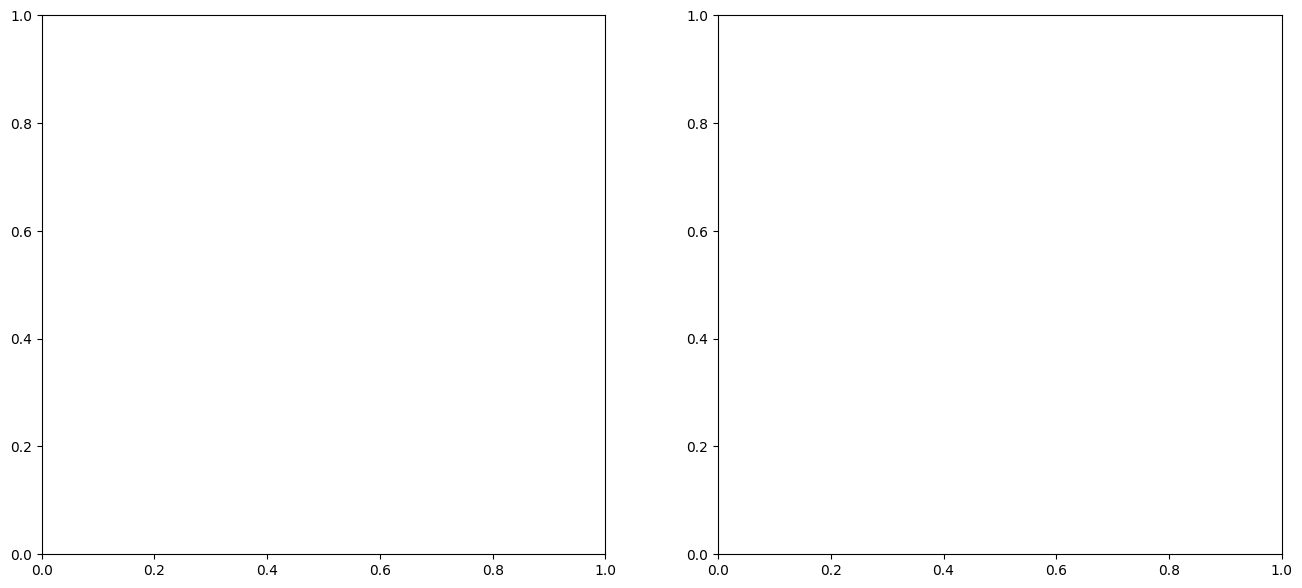

In [ ]:
# --- Visualizations ---
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

In [ ]:
# TSNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
z_tsne = tsne.fit_transform(all_latent)

Running t-SNE...


In [ ]:
sns.scatterplot(
    x=z_tsne[:,0], y=z_tsne[:,1],
    hue=[class_names[int(i)] for i in all_targets],
    palette='viridis', ax=axes[0]
)
axes[0].set_title(f't-SNE of Latent Space (True Labels)\nARI: {ari:.3f}')
axes[0].legend(prop={'size': 8})

In [ ]:
# UMAP (if available)
if HAS_UMAP:
    print("Running UMAP...")
    reducer = umap.UMAP(random_state=SEED)
    z_umap = reducer.fit_transform(all_latent)

    sns.scatterplot(
        x=z_umap[:,0], y=z_umap[:,1],
        hue=[class_names[int(i)] for i in all_targets],
        palette='viridis', ax=axes[1]
    )
    axes[1].set_title(f'UMAP of Latent Space (True Labels)\nNMI: {nmi:.3f}')
    axes[1].legend(prop={'size': 8})
else:
    axes[1].text(0.5, 0.5, 'UMAP Not Installed', ha='center')

Running UMAP...


In [ ]:
plt.tight_layout()
# plt.savefig('cluster_analysis.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- K-Means Clustering Analysis ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

>>> Running Independent K-Means Clustering...
    Number of Clusters (k): 4
    Silhouette Score: 0.1725
    Adjusted Rand Index (ARI):    -0.0436
    Normalized Mutual Info (NMI): 0.1319


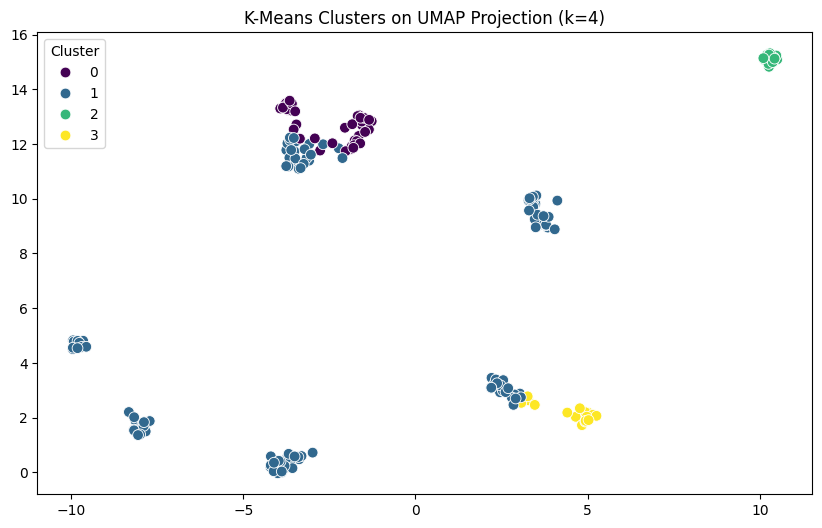

In [ ]:
# Ensure latent data is available
if 'all_latent' in locals():
    print(f">>> Running Independent K-Means Clustering...")

    # Determine K (number of clusters)
    # Uses len(class_names) if available, otherwise defaults to 4
    n_clusters = len(class_names) if 'class_names' in locals() else 4
    rand_seed = SEED if 'SEED' in locals() else 42

    print(f"    Number of Clusters (k): {n_clusters}")

    # 1. Fit K-Means
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=rand_seed)
    cluster_labels = kmeans_model.fit_predict(all_latent)

    # 2. Metrics
    sil_score = silhouette_score(all_latent, cluster_labels)
    print(f"    Silhouette Score: {sil_score:.4f}")

    if 'all_targets' in locals():
        ari_score = adjusted_rand_score(all_targets, cluster_labels)
        nmi_score = normalized_mutual_info_score(all_targets, cluster_labels)
        print(f"    Adjusted Rand Index (ARI):    {ari_score:.4f}")
        print(f"    Normalized Mutual Info (NMI): {nmi_score:.4f}")

    # 3. Visualization
    # Plots the K-Means clusters on top of existing UMAP or t-SNE results
    if 'z_umap' in locals():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=z_umap[:, 0], y=z_umap[:, 1], hue=cluster_labels, palette='viridis', s=60, legend='full')
        plt.title(f'K-Means Clusters on UMAP Projection (k={n_clusters})')
        plt.legend(title='Cluster')
        plt.show()
    elif 'z_tsne' in locals():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=cluster_labels, palette='viridis', s=60, legend='full')
        plt.title(f'K-Means Clusters on t-SNE Projection (k={n_clusters})')
        plt.legend(title='Cluster')
        plt.show()
    else:
        print("    Note: 'z_umap' or 'z_tsne' not found. Skipping visualization.")

In [ ]:
# else:
#     print("Error: 'all_latent' variable not found. Please run the evaluation cells above first.")


OMICS IMPACT ANALYSIS (%)
RNA Impact: 34.78% (+/- 3.15%)
Meth Impact: 35.34% (+/- 2.39%)
CNV Impact: 29.88% (+/- 3.64%)


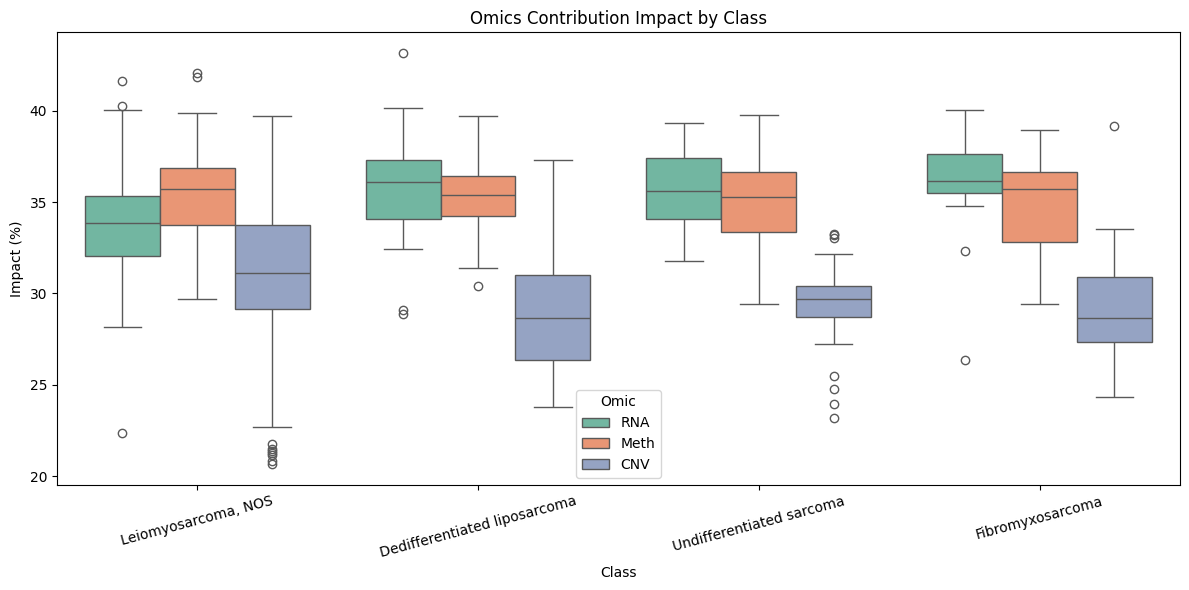

In [ ]:
# --- Omics Impact Analysis ---
if 'all_weights' in locals() and 'all_targets' in locals():
    print(f"\n{'='*30}")
    print("OMICS IMPACT ANALYSIS (%)")
    print(f"{'='*30}")

    # keys: 'RNA', 'Meth', 'CNV' -> values: (N,) arrays
    # Stack them: (N, 3)
    w_stack = np.stack([all_weights['RNA'], all_weights['Meth'], all_weights['CNV']], axis=1)
    omics_names = ['RNA', 'Meth', 'CNV']

    # Calculate percentage contribution per sample
    # w_stack sum across axis 1 might not be 1 if sigmoid outputs are independent.
    # Impact usually means relative contribution.
    w_sum = w_stack.sum(axis=1, keepdims=True)
    # Avoid division by zero
    w_sum[w_sum == 0] = 1e-8
    w_pct = (w_stack / w_sum) * 100

    # Global Mean
    mean_impact = w_pct.mean(axis=0)
    std_impact = w_pct.std(axis=0)

    for i, name in enumerate(omics_names):
        print(f"{name} Impact: {mean_impact[i]:.2f}% (+/- {std_impact[i]:.2f}%)")

    # By Class Analysis
    # Create DataFrame for easy plotting
    df_impact = pd.DataFrame(w_pct, columns=omics_names)
    df_impact['Class'] = [class_names[int(t)] for t in all_targets]

    # Melt for seaborn
    df_melt = df_impact.melt(id_vars='Class', var_name='Omic', value_name='Impact (%)')

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_melt, x='Class', y='Impact (%)', hue='Omic', palette='Set2')
    plt.title('Omics Contribution Impact by Class')
    plt.xticks(rotation=15)
    plt.tight_layout()
    # plt.savefig('omics_impact_analysis.png', dpi=300)
    plt.show()

In [ ]:
# else:
#     print("Error: 'all_weights' not found. Ensure you ran the updated evaluation loop.")


SHAP FEATURE IMPORTANCE ANALYSIS (Top 15 Genes per Omic)
Training a final model on full data for SHAP analysis...
   Training for SHAP (100 epochs)...
   Training complete.

>>> Calculating SHAP values for RNA...

>>> Calculating SHAP values for Methylation...

>>> Calculating SHAP values for CNV...

TOP 15 MOST IMPORTANT FEATURES (SHAP)

[RNA GENES]
   1. ENSG00000137142.5    (SHAP: 0.0121)
   2. ENSG00000249669.10   (SHAP: 0.0113)
   3. ENSG00000267060.7    (SHAP: 0.0097)
   4. ENSG00000147166.11   (SHAP: 0.0095)

[METHYLATION PROBES]
   1. cg11609668           (SHAP: 0.0204)
   2. cg23774717           (SHAP: 0.0109)
   3. cg13068653           (SHAP: 0.0093)
   4. cg11344729           (SHAP: 0.0066)

[CNV GENES]
   1. ENSG00000166225.9    (SHAP: 0.0045)
   2. ENSG00000135679.25   (SHAP: 0.0036)
   3. ENSG00000256678.1    (SHAP: 0.0021)
   4. ENSG00000264405.1    (SHAP: 0.0016)


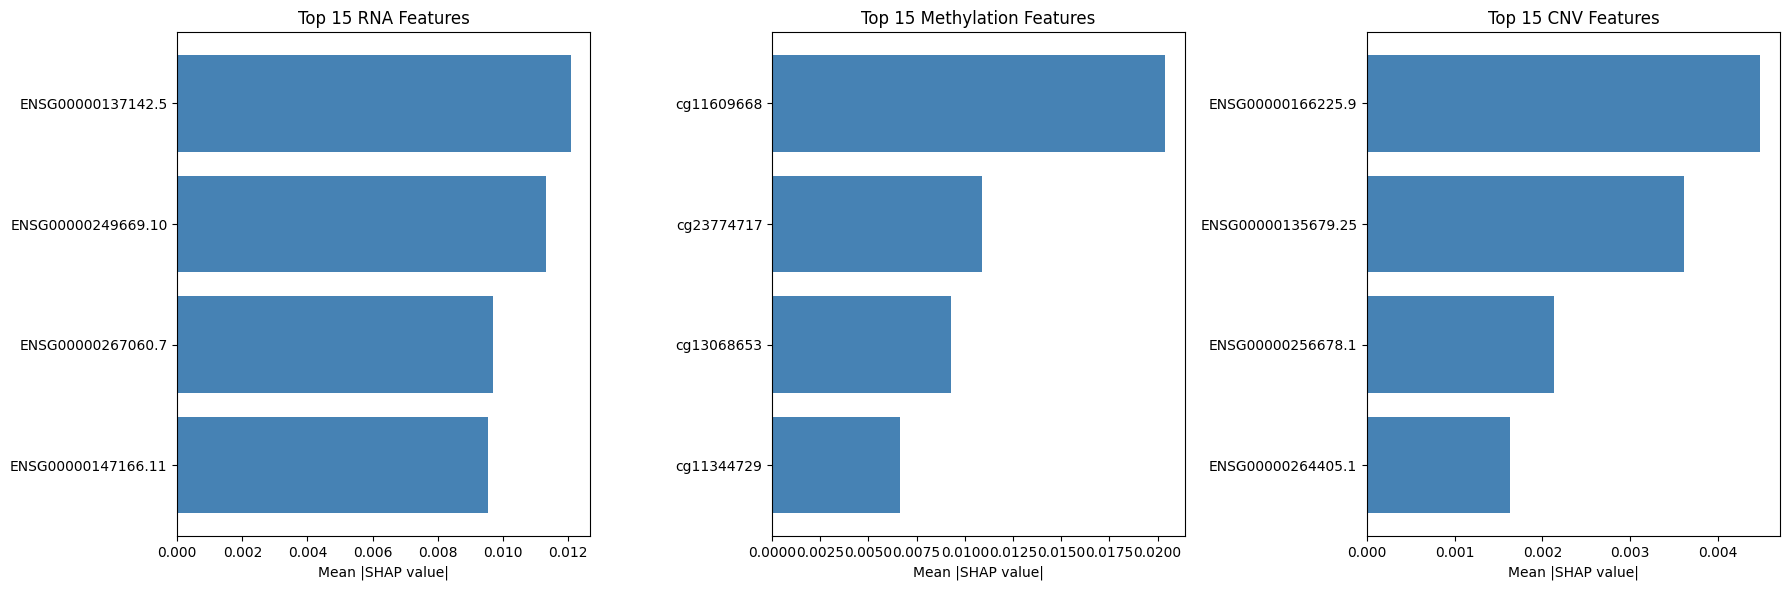

In [ ]:
# ==============================================================================
# SHAP FEATURE IMPORTANCE ANALYSIS
# ==============================================================================
if HAS_SHAP and 'rna_df' in locals():
    print(f"\n{'='*60}")
    print("SHAP FEATURE IMPORTANCE ANALYSIS (Top 15 Genes per Omic)")
    print(f"{'='*60}")
    print("Training a final model on full data for SHAP analysis...")

    # --- Prepare Full Data (No CV, just for SHAP) ---
    def prepare_full_data_for_shap(df_rna, df_meth, df_cnv, Y):
        """Prepare full dataset for SHAP, returning feature names."""
        rna_cols = df_rna.columns.tolist()
        meth_cols = df_meth.columns.tolist()
        cnv_cols = df_cnv.columns.tolist()

        X_r = df_rna.values
        X_m = df_meth.values
        X_c = df_cnv.values

        # Variance Filter
        def var_filter_with_names(X, names, top_k):
            if X.shape[1] <= top_k:
                return X, names
            vars = np.nanvar(X, axis=0)
            top_idx = np.argsort(vars)[-top_k:]
            return X[:, top_idx], [names[i] for i in top_idx]

        X_r, rna_cols = var_filter_with_names(X_r, rna_cols, 5000)
        X_m, meth_cols = var_filter_with_names(X_m, meth_cols, 10000)
        X_c, cnv_cols = var_filter_with_names(X_c, cnv_cols, 8000)

        # KNN Imputation
        imp = KNNImputer(n_neighbors=12)
        X_r = imp.fit_transform(X_r)
        X_m = imp.fit_transform(X_m)
        X_c = imp.fit_transform(X_c)

        # mRMR Filter with names
        def mrmr_with_names(X, y, names, top_k):
            if X.shape[1] <= top_k:
                return X, names
            if HAS_CUPY:
                try:
                    selected_indices = mrmr_gpu_impl(X, y, top_k)
                    if hasattr(selected_indices, 'get'): selected_indices = selected_indices.get()
                    selected_indices = list(selected_indices)
                    return X[:, selected_indices], [names[i] for i in selected_indices]
                except:
                    pass
            if HAS_MRMR:
                df_temp = pd.DataFrame(X, columns=[f"f_{i}" for i in range(X.shape[1])])
                selected_feats = mrmr_classif(X=df_temp, y=pd.Series(y), K=top_k, show_progress=False)
                selected_indices = [int(f.split('_')[1]) for f in selected_feats]
                return X[:, selected_indices], [names[i] for i in selected_indices]
            # Fallback to variance
            vars = np.nanvar(X, axis=0)
            top_idx = np.argsort(vars)[-top_k:]
            return X[:, top_idx], [names[i] for i in top_idx]

        X_r, rna_cols = mrmr_with_names(X_r, Y, rna_cols, 500)
        X_m, meth_cols = mrmr_with_names(X_m, Y, meth_cols, 400)
        X_c, cnv_cols = mrmr_with_names(X_c, Y, cnv_cols, 300)

        # Scale
        sc = StandardScaler()
        X_r = sc.fit_transform(X_r)
        X_m = sc.fit_transform(X_m)
        X_c = sc.fit_transform(X_c)

        return (
            torch.FloatTensor(X_r).to(DEVICE),
            torch.FloatTensor(X_m).to(DEVICE),
            torch.FloatTensor(X_c).to(DEVICE),
            torch.LongTensor(Y).to(DEVICE),
            rna_cols, meth_cols, cnv_cols
        )

    X_r_full, X_m_full, X_c_full, Y_full, rna_names, meth_names, cnv_names = \
        prepare_full_data_for_shap(rna_df, meth_df, cnv_df, Y)

    # --- Train Final Model ---
    enc_r_shap = PerOmicCMAE(X_r_full.shape[1], BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_encoder']).to(DEVICE)
    enc_m_shap = PerOmicCMAE(X_m_full.shape[1], BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_encoder']).to(DEVICE)
    enc_c_shap = PerOmicCMAE(X_c_full.shape[1], BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_encoder']).to(DEVICE)
    fusion_shap = GatedAttentionFusion(BEST_PARAMS['latent_dim'], len(class_names), BEST_PARAMS['dropout_rate'], BEST_PARAMS['fusion_hidden_dim']).to(DEVICE)

    optimizer_shap = optim.AdamW(
        list(enc_r_shap.parameters()) + list(enc_m_shap.parameters()) +
        list(enc_c_shap.parameters()) + list(fusion_shap.parameters()),
        lr=BEST_PARAMS['lr_fine'], weight_decay=BEST_PARAMS['weight_decay']
    )
    alpha_shap = torch.FloatTensor(class_weights * BEST_PARAMS['alpha_scale']).to(DEVICE)
    criterion_shap = FocalLoss(gamma=BEST_PARAMS['focal_gamma'], alpha=alpha_shap)

    print("   Training for SHAP (100 epochs)...")
    for epoch in range(100):
        enc_r_shap.train(); enc_m_shap.train(); enc_c_shap.train(); fusion_shap.train()
        z_r = enc_r_shap(X_r_full, noise_level=BEST_PARAMS['noise_level'])
        z_m = enc_m_shap(X_m_full, noise_level=BEST_PARAMS['noise_level'])
        z_c = enc_c_shap(X_c_full, noise_level=BEST_PARAMS['noise_level'])
        logits, _ = fusion_shap(z_r, z_m, z_c, apply_dropout=False)
        loss = criterion_shap(logits, Y_full)
        optimizer_shap.zero_grad()
        loss.backward()
        optimizer_shap.step()
    print("   Training complete.")

    # --- SHAP Analysis per Encoder ---
    enc_r_shap.eval(); enc_m_shap.eval(); enc_c_shap.eval(); fusion_shap.eval()

    def get_shap_importance(encoder, fusion_model, X_data, X_r_bg, X_m_bg, X_c_bg, omic_type, feature_names, top_n=20):
        """
        Calculate SHAP values for a single encoder.
        Uses GradientExplainer for neural network.
        """
        # Wrapper that takes one omic and uses fixed background for others
        class EncoderWrapper(nn.Module):
            def __init__(self, enc, fus, omic, bg_r, bg_m, bg_c):
                super().__init__()
                self.enc = enc
                self.fus = fus
                self.omic = omic
                # Use mean of background
                self.bg_r = bg_r.mean(0, keepdim=True)
                self.bg_m = bg_m.mean(0, keepdim=True)
                self.bg_c = bg_c.mean(0, keepdim=True)

            def forward(self, x):
                batch_size = x.shape[0]
                if self.omic == 'RNA':
                    z_r = self.enc(x)
                    z_m = enc_m_shap(self.bg_m.expand(batch_size, -1))
                    z_c = enc_c_shap(self.bg_c.expand(batch_size, -1))
                elif self.omic == 'Meth':
                    z_r = enc_r_shap(self.bg_r.expand(batch_size, -1))
                    z_m = self.enc(x)
                    z_c = enc_c_shap(self.bg_c.expand(batch_size, -1))
                else:  # CNV
                    z_r = enc_r_shap(self.bg_r.expand(batch_size, -1))
                    z_m = enc_m_shap(self.bg_m.expand(batch_size, -1))
                    z_c = self.enc(x)
                logits, _ = self.fus(z_r, z_m, z_c)
                return logits

        wrapper = EncoderWrapper(encoder, fusion_model, omic_type, X_r_bg, X_m_bg, X_c_bg)

        # Use a small background sample
        bg_sample = X_data[:min(50, len(X_data))]

        explainer = shap.GradientExplainer(wrapper, bg_sample)
        shap_values = explainer.shap_values(X_data[:min(100, len(X_data))])

        # shap_values execution check
        if shap_values is None: 
            return []

        # Convert to numpy array safely
        # Result should be (classes, samples, features) or (samples, features)
        try:
            vals = np.array(shap_values)
        except:
            # Fallback for ragged lists? (shouldnt happen here)
            vals = np.array(shap_values[0])

        # Calculate mean absolute importance
        # We want (n_features,)
        if vals.ndim == 3: # (classes, samples, features)
            shap_abs = np.mean(np.abs(vals), axis=(0, 1))
        elif vals.ndim == 2: # (samples, features)
            shap_abs = np.mean(np.abs(vals), axis=0)
        else:
             # Odd shape, flatten everything to be safe or take mean
             shap_abs = np.mean(np.abs(vals.reshape(-1, vals.shape[-1])), axis=0)

        # Ensure flat vector
        shap_abs = shap_abs.flatten()

        # Get top N
        if len(shap_abs) == 0: return []
        
        # Argsort gives indices of sorted array
        # Take last N (highest values) and reverse
        top_indices = np.argsort(shap_abs)[-top_n:][::-1]
        
        top_features = []
        for idx in top_indices:
             # Convert numpy int to python int for list indexing
             i = int(idx) 
             if i < len(feature_names):
                 top_features.append( (feature_names[i], float(shap_abs[i])) )
             else:
                 top_features.append( (f"Unknown_{i}", float(shap_abs[i])) )

        return top_features

    print("\n>>> Calculating SHAP values for RNA...")
    top_rna = get_shap_importance(enc_r_shap, fusion_shap, X_r_full, X_r_full, X_m_full, X_c_full, 'RNA', rna_names)
    print("\n>>> Calculating SHAP values for Methylation...")
    top_meth = get_shap_importance(enc_m_shap, fusion_shap, X_m_full, X_r_full, X_m_full, X_c_full, 'Meth', meth_names)
    print("\n>>> Calculating SHAP values for CNV...")
    top_cnv = get_shap_importance(enc_c_shap, fusion_shap, X_c_full, X_r_full, X_m_full, X_c_full, 'CNV', cnv_names)

    # --- Print Results ---
    print(f"\n{'='*50}")
    print("TOP 15 MOST IMPORTANT FEATURES (SHAP)")
    print(f"{'='*50}")

    print("\n[RNA GENES]")
    for i, (name, score) in enumerate(top_rna, 1):
        print(f"  {i:2d}. {name:20s} (SHAP: {score:.4f})")

    print("\n[METHYLATION PROBES]")
    for i, (name, score) in enumerate(top_meth, 1):
        print(f"  {i:2d}. {name:20s} (SHAP: {score:.4f})")

    print("\n[CNV GENES]")
    for i, (name, score) in enumerate(top_cnv, 1):
        print(f"  {i:2d}. {name:20s} (SHAP: {score:.4f})")

    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for ax, (title, data) in zip(axes, [('RNA', top_rna), ('Methylation', top_meth), ('CNV', top_cnv)]):
        names = [x[0] for x in data][::-1]
        scores = [x[1] for x in data][::-1]
        ax.barh(names, scores, color='steelblue')
        ax.set_xlabel('Mean |SHAP value|')
        ax.set_title(f'Top 15 {title} Features')

    plt.tight_layout()
    plt.savefig('shap_feature_importance.png', dpi=300)
    plt.show()

>>> MyGene detected. Gene ID conversion enabled.

SHAP FEATURE IMPORTANCE ANALYSIS (Top 15 Genes per Omic)
Training a final model on full data for SHAP analysis...
   Training for SHAP (100 epochs)...
   Training complete.

>>> Calculating SHAP values for RNA...
   Generating SHAP summary for RNA...


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


      mapping RNA Ensembl IDs to Symbols...


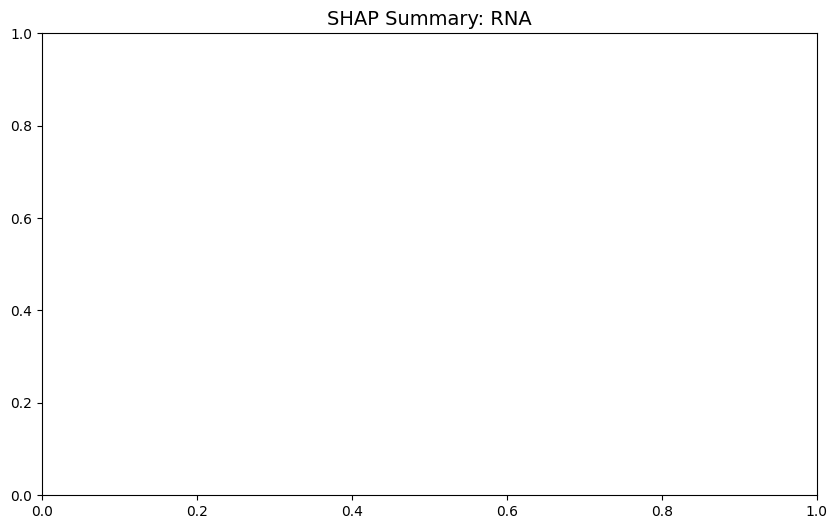

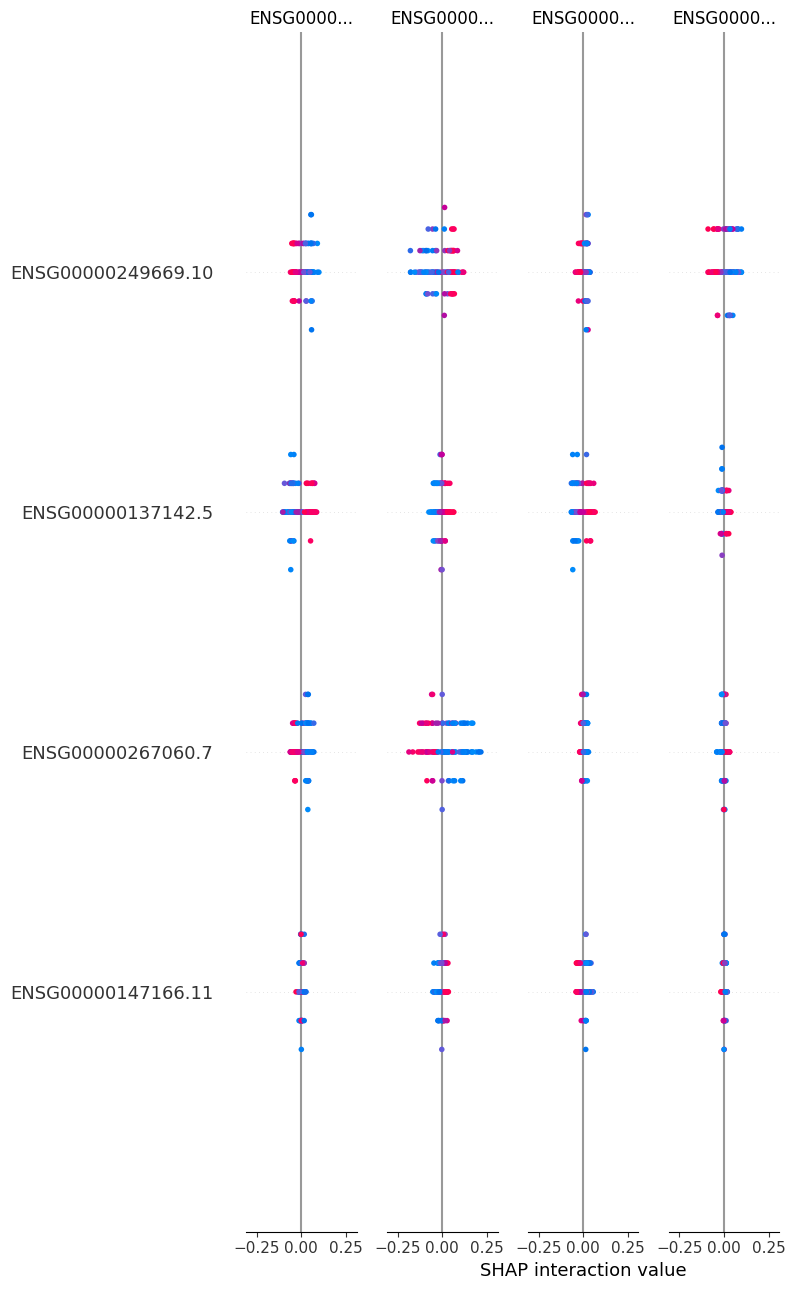


[RNA TOP 15]
   1. Unknown_Idx_1484     (SHAP: 0.0754)
   2. ENSG00000277702.1    (SHAP: 0.0728)
   3. Unknown_Idx_1840     (SHAP: 0.0717)
   4. Unknown_Idx_1529     (SHAP: 0.0712)
   5. Unknown_Idx_612      (SHAP: 0.0701)
   6. Unknown_Idx_692      (SHAP: 0.0660)
   7. Unknown_Idx_1953     (SHAP: 0.0657)
   8. Unknown_Idx_1072     (SHAP: 0.0656)
   9. ENSG00000225279.2    (SHAP: 0.0629)
  10. Unknown_Idx_1672     (SHAP: 0.0608)
  11. Unknown_Idx_988      (SHAP: 0.0600)
  12. Unknown_Idx_1864     (SHAP: 0.0595)
  13. ENSG00000255727.2    (SHAP: 0.0594)
  14. Unknown_Idx_1525     (SHAP: 0.0574)
  15. Unknown_Idx_1744     (SHAP: 0.0568)
   Generating SHAP summary for Meth...


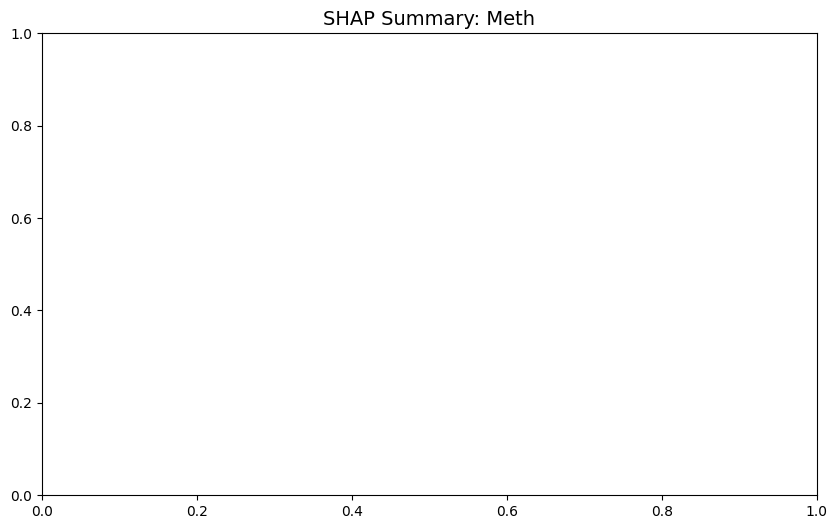

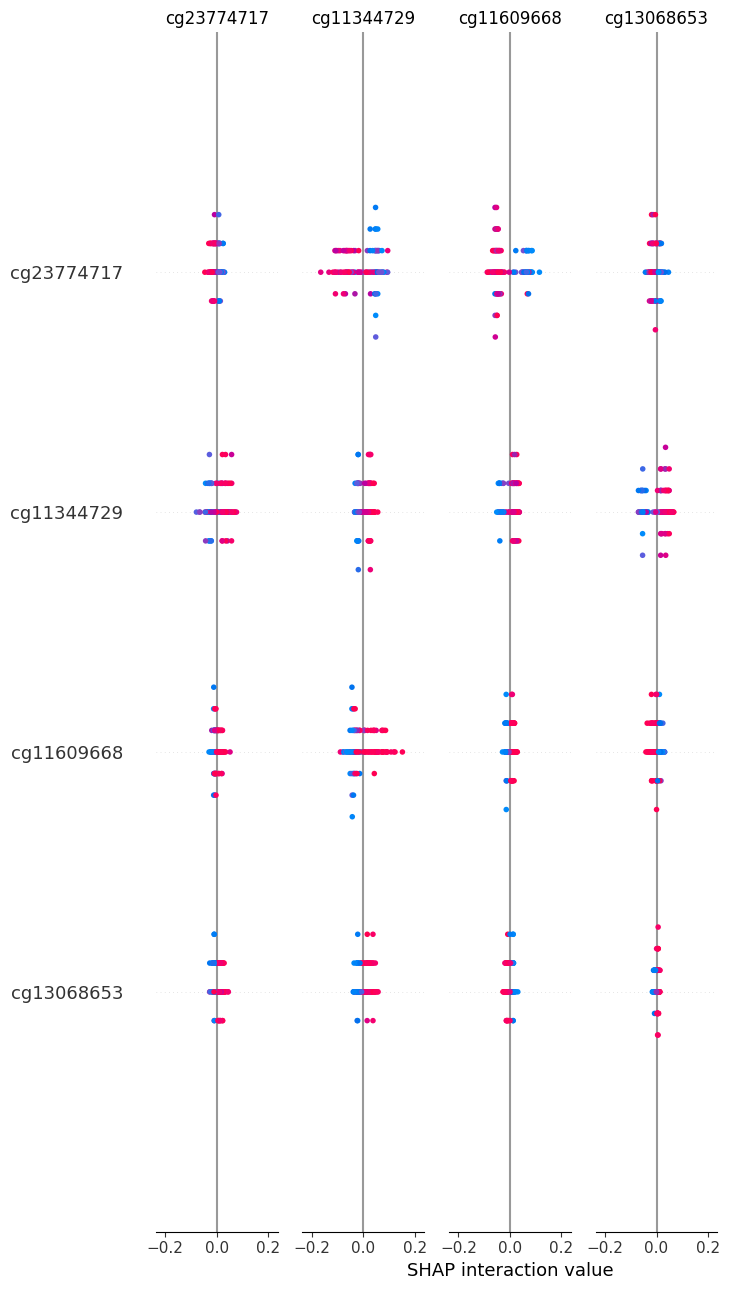


[Meth TOP 15]
   1. Unknown_Idx_445      (SHAP: 0.0720)
   2. Unknown_Idx_446      (SHAP: 0.0571)
   3. Unknown_Idx_709      (SHAP: 0.0494)
   4. cg19457909           (SHAP: 0.0476)
   5. cg01644611           (SHAP: 0.0462)
   6. Unknown_Idx_665      (SHAP: 0.0458)
   7. Unknown_Idx_1405     (SHAP: 0.0451)
   8. cg24996981           (SHAP: 0.0426)
   9. cg19501190           (SHAP: 0.0425)
  10. Unknown_Idx_710      (SHAP: 0.0421)
  11. Unknown_Idx_1406     (SHAP: 0.0419)
  12. cg07575896           (SHAP: 0.0415)
  13. Unknown_Idx_541      (SHAP: 0.0414)
  14. cg19764370           (SHAP: 0.0408)
  15. Unknown_Idx_1361     (SHAP: 0.0403)
   Generating SHAP summary for CNV...


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


      mapping CNV Ensembl IDs to Symbols...


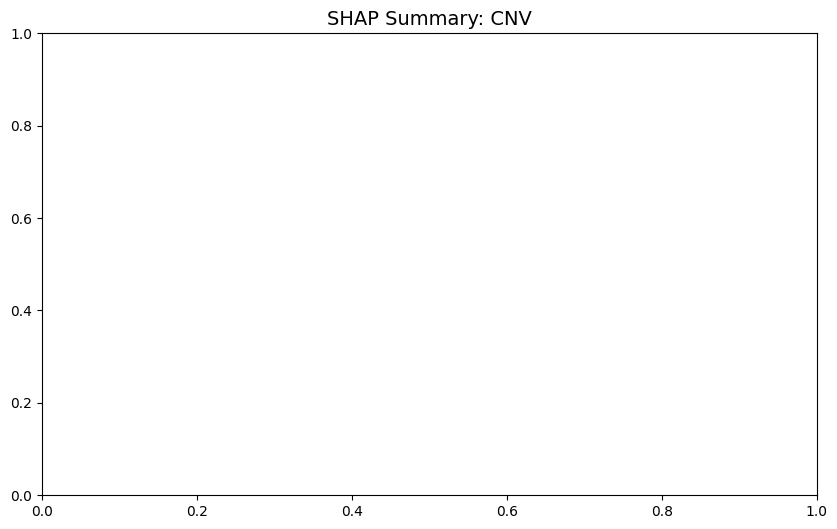

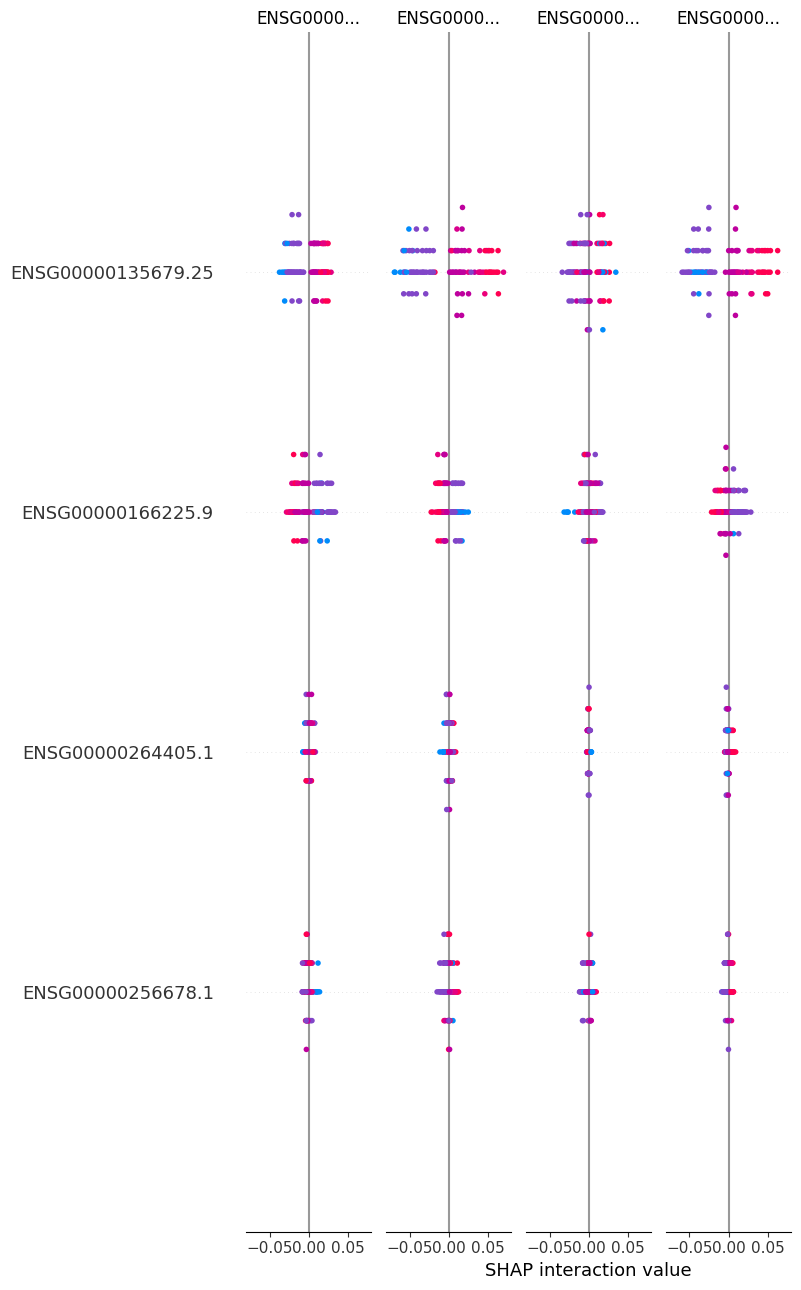


[CNV TOP 15]
   1. ENSG00000284646.1    (SHAP: 0.0181)
   2. ENSG00000257507.1    (SHAP: 0.0179)
   3. Unknown_Idx_744      (SHAP: 0.0174)
   4. ENSG00000135679.25   (SHAP: 0.0171)
   5. ENSG00000148719.15   (SHAP: 0.0167)
   6. Unknown_Idx_376      (SHAP: 0.0167)
   7. ENSG00000135439.11   (SHAP: 0.0166)
   8. ENSG00000239810.3    (SHAP: 0.0162)
   9. ENSG00000173614.14   (SHAP: 0.0158)
  10. ENSG00000175782.11   (SHAP: 0.0156)
  11. ENSG00000283677.1    (SHAP: 0.0151)
  12. ENSG00000284616.1    (SHAP: 0.0147)
  13. ENSG00000162441.12   (SHAP: 0.0147)
  14. ENSG00000221817.10   (SHAP: 0.0144)
  15. Unknown_Idx_378      (SHAP: 0.0136)


In [201]:

try:
    import mygene
    HAS_MYGENE = True
    print(">>> MyGene detected. Gene ID conversion enabled.")
except ImportError:
    HAS_MYGENE = False
    print("Warning: mygene not installed. Gene IDs will be used as-is.")
# ==============================================================================
# SHAP FEATURE IMPORTANCE ANALYSIS
# ==============================================================================
if HAS_SHAP and 'rna_df' in locals():
    print(f"\n{'='*60}")
    print("SHAP FEATURE IMPORTANCE ANALYSIS (Top 15 Genes per Omic)")
    print(f"{'='*60}")
    print("Training a final model on full data for SHAP analysis...")

    # --- Prepare Full Data (No CV, just for SHAP) ---
    def prepare_full_data_for_shap(df_rna, df_meth, df_cnv, Y):
        """Prepare full dataset for SHAP, returning feature names."""
        rna_cols = df_rna.columns.tolist()
        meth_cols = df_meth.columns.tolist()
        cnv_cols = df_cnv.columns.tolist()

        X_r = df_rna.values
        X_m = df_meth.values
        X_c = df_cnv.values

        # Variance Filter
        def var_filter_with_names(X, names, top_k):
            if X.shape[1] <= top_k:
                return X, names
            vars = np.nanvar(X, axis=0)
            top_idx = np.argsort(vars)[-top_k:]
            return X[:, top_idx], [names[i] for i in top_idx]

        X_r, rna_cols = var_filter_with_names(X_r, rna_cols, 5000)
        X_m, meth_cols = var_filter_with_names(X_m, meth_cols, 10000)
        X_c, cnv_cols = var_filter_with_names(X_c, cnv_cols, 8000)

        # KNN Imputation
        imp = KNNImputer(n_neighbors=12)
        X_r = imp.fit_transform(X_r)
        X_m = imp.fit_transform(X_m)
        X_c = imp.fit_transform(X_c)

        # mRMR Filter with names
        def mrmr_with_names(X, y, names, top_k):
            if X.shape[1] <= top_k:
                return X, names
            if HAS_CUPY:
                try:
                    selected_indices = mrmr_gpu_impl(X, y, top_k)
                    if hasattr(selected_indices, 'get'): selected_indices = selected_indices.get()
                    selected_indices = list(selected_indices)
                    return X[:, selected_indices], [names[i] for i in selected_indices]
                except:
                    pass
            if HAS_MRMR:
                df_temp = pd.DataFrame(X, columns=[f"f_{i}" for i in range(X.shape[1])])
                selected_feats = mrmr_classif(X=df_temp, y=pd.Series(y), K=top_k, show_progress=False)
                selected_indices = [int(f.split('_')[1]) for f in selected_feats]
                return X[:, selected_indices], [names[i] for i in selected_indices]
            # Fallback to variance
            vars = np.nanvar(X, axis=0)
            top_idx = np.argsort(vars)[-top_k:]
            return X[:, top_idx], [names[i] for i in top_idx]

        X_r, rna_cols = mrmr_with_names(X_r, Y, rna_cols, 500)
        X_m, meth_cols = mrmr_with_names(X_m, Y, meth_cols, 400)
        X_c, cnv_cols = mrmr_with_names(X_c, Y, cnv_cols, 300)

        # Scale
        sc = StandardScaler()
        X_r = sc.fit_transform(X_r)
        X_m = sc.fit_transform(X_m)
        X_c = sc.fit_transform(X_c)

        return (
            torch.FloatTensor(X_r).to(DEVICE),
            torch.FloatTensor(X_m).to(DEVICE),
            torch.FloatTensor(X_c).to(DEVICE),
            torch.LongTensor(Y).to(DEVICE),
            rna_cols, meth_cols, cnv_cols
        )

    X_r_full, X_m_full, X_c_full, Y_full, rna_names, meth_names, cnv_names = \
        prepare_full_data_for_shap(rna_df, meth_df, cnv_df, Y)

    # --- Train Final Model ---
    enc_r_shap = PerOmicCMAE(X_r_full.shape[1], BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_encoder']).to(DEVICE)
    enc_m_shap = PerOmicCMAE(X_m_full.shape[1], BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_encoder']).to(DEVICE)
    enc_c_shap = PerOmicCMAE(X_c_full.shape[1], BEST_PARAMS['latent_dim'], BEST_PARAMS['hidden_dim'], BEST_PARAMS['dropout_encoder']).to(DEVICE)
    fusion_shap = GatedAttentionFusion(BEST_PARAMS['latent_dim'], len(class_names), BEST_PARAMS['dropout_rate'], BEST_PARAMS['fusion_hidden_dim']).to(DEVICE)

    optimizer_shap = optim.AdamW(
        list(enc_r_shap.parameters()) + list(enc_m_shap.parameters()) +
        list(enc_c_shap.parameters()) + list(fusion_shap.parameters()),
        lr=BEST_PARAMS['lr_fine'], weight_decay=BEST_PARAMS['weight_decay']
    )
    alpha_shap = torch.FloatTensor(class_weights * BEST_PARAMS['alpha_scale']).to(DEVICE)
    criterion_shap = FocalLoss(gamma=BEST_PARAMS['focal_gamma'], alpha=alpha_shap)

    print("   Training for SHAP (100 epochs)...")
    for epoch in range(100):
        enc_r_shap.train(); enc_m_shap.train(); enc_c_shap.train(); fusion_shap.train()
        z_r = enc_r_shap(X_r_full, noise_level=BEST_PARAMS['noise_level'])
        z_m = enc_m_shap(X_m_full, noise_level=BEST_PARAMS['noise_level'])
        z_c = enc_c_shap(X_c_full, noise_level=BEST_PARAMS['noise_level'])
        logits, _ = fusion_shap(z_r, z_m, z_c, apply_dropout=False)
        loss = criterion_shap(logits, Y_full)
        optimizer_shap.zero_grad()
        loss.backward()
        optimizer_shap.step()
    print("   Training complete.")

    # --- SHAP Analysis per Encoder ---
    enc_r_shap.eval(); enc_m_shap.eval(); enc_c_shap.eval(); fusion_shap.eval()

    def get_shap_importance(encoder, fusion_model, X_data, X_r_bg, X_m_bg, X_c_bg, omic_type, feature_names, top_n=15):
        """
        Calculate SHAP values for a single encoder.
        Uses GradientExplainer for neural network.
        """
        # Wrapper that takes one omic and uses fixed background for others
        class EncoderWrapper(nn.Module):
            def __init__(self, enc, fus, omic, bg_r, bg_m, bg_c):
                super().__init__()
                self.enc = enc
                self.fus = fus
                self.omic = omic
                # Use mean of background
                self.bg_r = bg_r.mean(0, keepdim=True)
                self.bg_m = bg_m.mean(0, keepdim=True)
                self.bg_c = bg_c.mean(0, keepdim=True)

            def forward(self, x):
                batch_size = x.shape[0]
                if self.omic == 'RNA':
                    z_r = self.enc(x)
                    z_m = enc_m_shap(self.bg_m.expand(batch_size, -1))
                    z_c = enc_c_shap(self.bg_c.expand(batch_size, -1))
                elif self.omic == 'Meth':
                    z_r = enc_r_shap(self.bg_r.expand(batch_size, -1))
                    z_m = self.enc(x)
                    z_c = enc_c_shap(self.bg_c.expand(batch_size, -1))
                else:  # CNV
                    z_r = enc_r_shap(self.bg_r.expand(batch_size, -1))
                    z_m = enc_m_shap(self.bg_m.expand(batch_size, -1))
                    z_c = self.enc(x)
                logits, _ = self.fus(z_r, z_m, z_c)
                return logits

        wrapper = EncoderWrapper(encoder, fusion_model, omic_type, X_r_bg, X_m_bg, X_c_bg)

        # Use a small background sample
        bg_sample = X_data[:min(50, len(X_data))]

        explainer = shap.GradientExplainer(wrapper, bg_sample)
        shap_values = explainer.shap_values(X_data[:min(100, len(X_data))])

        # shap_values execution check
        if shap_values is None: 
            return []

        # Convert to numpy array safely
        # Result should be (classes, samples, features) or (samples, features)
        try:
            vals = np.array(shap_values)
        except:
            # Fallback for ragged lists? (shouldnt happen here)
            vals = np.array(shap_values[0])

        # Calculate mean absolute importance
        # We want (n_features,)
        if vals.ndim == 3: # (classes, samples, features)
            shap_abs = np.mean(np.abs(vals), axis=(0, 1))
        elif vals.ndim == 2: # (samples, features)
            shap_abs = np.mean(np.abs(vals), axis=0)
        else:
             # Odd shape, flatten everything to be safe or take mean
             shap_abs = np.mean(np.abs(vals.reshape(-1, vals.shape[-1])), axis=0)

        # Ensure flat vector
        shap_abs = shap_abs.flatten()

        # Get top N
        if len(shap_abs) == 0: return []
        
        # Argsort gives indices of sorted array
        # Take last N (highest values) and reverse
        top_indices = np.argsort(shap_abs)[-top_n:][::-1]
        
        top_features = []
        for idx in top_indices:
             # Convert numpy int to python int for list indexing
             i = int(idx) 
             if i < len(feature_names):
                 top_features.append( (feature_names[i], float(shap_abs[i])) )
             else:
                 top_features.append( (f"Unknown_{i}", float(shap_abs[i])) )

        return top_features

    print("\n>>> Calculating SHAP values for RNA...")
    # top_rna is list of (name, score)
    # We need the RAW shap values and the TEST data for the summary plot
    # Re-running explainer for plot data
    def get_shap_data_for_plot(encoder, fusion_model, X_data, X_r_bg, X_m_bg, X_c_bg, omic_type):
        class EncoderWrapper(nn.Module):
            def __init__(self, enc, fus, omic, bg_r, bg_m, bg_c):
                super().__init__()
                self.enc = enc
                self.fus = fus
                self.omic = omic
                self.bg_r = bg_r.mean(0, keepdim=True)
                self.bg_m = bg_m.mean(0, keepdim=True)
                self.bg_c = bg_c.mean(0, keepdim=True)
            def forward(self, x):
                batch_size = x.shape[0]
                if self.omic == 'RNA':
                    z_r = self.enc(x)
                    z_m = enc_m_shap(self.bg_m.expand(batch_size, -1))
                    z_c = enc_c_shap(self.bg_c.expand(batch_size, -1))
                elif self.omic == 'Meth':
                    z_r = enc_r_shap(self.bg_r.expand(batch_size, -1))
                    z_m = self.enc(x)
                    z_c = enc_c_shap(self.bg_c.expand(batch_size, -1))
                else: 
                    z_r = enc_r_shap(self.bg_r.expand(batch_size, -1))
                    z_m = enc_m_shap(self.bg_m.expand(batch_size, -1))
                    z_c = self.enc(x)
                logits, _ = self.fus(z_r, z_m, z_c)
                return logits

        wrapper = EncoderWrapper(encoder, fusion_model, omic_type, X_r_bg, X_m_bg, X_c_bg)
        bg = X_data[:min(50, len(X_data))]
        test = X_data[:min(100, len(X_data))]
        
        # Use GradientExplainer
        explainer = shap.GradientExplainer(wrapper, bg)
        # Note: GradientExplainer returns list for classes. 
        # We'll take the class of interest (e.g. index 1) or average.
        # For summary plot we usually want one specific class or multiclass.
        shap_vals = explainer.shap_values(test)
        return shap_vals, test.cpu().numpy()

    # --- helper to process and plot ---
    def process_and_plot_shap(omic_name, encoder, X_full, feat_names):
        print(f"   Generating SHAP summary for {omic_name}...")
        shap_vals_raw, X_test_np = get_shap_data_for_plot(encoder, fusion_shap, X_full, X_r_full, X_m_full, X_c_full, omic_name)
        
        # Handle list of arrays (multiclass) -> Pick class 0 or aggregate
        if isinstance(shap_vals_raw, list):
             # Just use Class 0 for visualization or absolute sum
             # For summary plot, we need (samples, features)
             sv = shap_vals_raw[0] 
        else:
             sv = shap_vals_raw

        # Gene Name Conversion
        display_names = feat_names
        if HAS_MYGENE and omic_name in ['RNA', 'CNV']:
            # Check first few
            if len(feat_names) > 0 and (str(feat_names[0]).startswith('ENSG') or 'ENSG' in str(feat_names[0])):
                print(f"      mapping {omic_name} Ensembl IDs to Symbols...")
                mg = mygene.MyGeneInfo()
                try:
                    res = mg.querymany(feat_names, scopes='ensembl.gene', fields='symbol', species='human', verbose=False)
                    # Create mapping
                    mapping = {item['query']: item.get('symbol', item['query']) for item in res}
                    display_names = [mapping.get(n, n) for n in feat_names]
                except Exception as e:
                    print(f"      MyGene query failed: {e}")

        # Summary Plot
        plt.figure(figsize=(10, 6))
        plt.title(f"SHAP Summary: {omic_name}", fontsize=14)
        shap.summary_plot(sv, X_test_np, feature_names=display_names, max_display=15, show=False, plot_type='dot')
        plt.tight_layout()
        plt.savefig(f'shap_summary_{omic_name}.png', dpi=300)
        plt.show() # Attempt to show inline if possible
        
        # Print Text Data using the computed SHAP values
        # Mean |SHAP|
        # sv might be (samples, features)
        if sv.ndim > 1:
            mean_shap = np.mean(np.abs(sv), axis=0)
        else:
            mean_shap = np.abs(sv)
            
        mean_shap = mean_shap.flatten() # Ensure 1D

        top_ids = np.argsort(mean_shap)[-15:][::-1]
        
        print(f"\n[{omic_name} TOP 15]")
        for i, idx in enumerate(top_ids, 1):
            # Ensure idx is a simple python int
            idx_scalar = int(idx)
            if idx_scalar < len(display_names):
                vn = display_names[idx_scalar]
            else:
                vn = f"Unknown_Idx_{idx_scalar}"
                
            vs = float(mean_shap[idx_scalar])
            print(f"  {i:2d}. {vn:20s} (SHAP: {vs:.4f})")

    process_and_plot_shap('RNA', enc_r_shap, X_r_full, rna_names)
    process_and_plot_shap('Meth', enc_m_shap, X_m_full, meth_names)
    process_and_plot_shap('CNV', enc_c_shap, X_c_full, cnv_names)


else:
    if not HAS_SHAP:
        print("\nSHAP analysis skipped: shap library not installed.")
    else:
        print("\nSHAP analysis skipped: Required data not available.")